# Approach 1 : Baseline 2d cnn

In [ ]:
import torch # import necessary libraries and modules
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, Dataset
from torchvision import transforms, datasets, models
import matplotlib.pyplot as plt
import numpy as np
import os
from tqdm import tqdm

In [3]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using:", device)

Using: cpu


# Data load, preprocessing and transforms

In [ ]:
data_dir="../data_frames"
BATCH_SIZE=32
IMG_SIZE=224

# Transform pipeline for single-frame images:
# resize, tensor, normalize with ImageNet statistics
transform=transforms.Compose([
    transforms.Resize((IMG_SIZE,IMG_SIZE)),   # resize all frames to 224×224
    transforms.ToTensor(), # convert PIL image to PyTorch tensor
    transforms.Normalize(mean=[0.485,0.456,0.406],
                         std=[0.229,0.224,0.225])])  # standard ImageNet normalization

# Load train/val/test splits
train_data=datasets.ImageFolder(os.path.join(data_dir,"train"),transform=transform)
val_data=datasets.ImageFolder(os.path.join(data_dir,"val"),transform=transform)
test_data=datasets.ImageFolder(os.path.join(data_dir,"test"),transform=transform)

# Wrap datasets in DataLoaders for batching and efficient iteration
train_loader=DataLoader(train_data,batch_size=BATCH_SIZE,shuffle=True) # shuffle for stochastic training
val_loader=DataLoader(val_data,batch_size=BATCH_SIZE,shuffle=False)   # deterministic evaluation
test_loader=DataLoader(test_data,batch_size=BATCH_SIZE,shuffle=False)     # final test evaluation

print("Classes:",train_data.classes)
print("Train images:",len(train_data))
print("Val images:",len(val_data))
print("Test images:",len(test_data))


Classes: ['backhand', 'forehand', 'nostroke', 'serves']
Train images: 1265
Val images: 158
Test images: 158


# Model Definition (2D CNN)

In [ ]:
class BaselineCNN(nn.Module):
    def __init__(self,num_classes=4):
        super(BaselineCNN,self).__init__()

        # Convolutional backbone learns spatial features from a single RGB frame
        self.conv_layers=nn.Sequential(
            nn.Conv2d(3,32,kernel_size=3,padding=1),  # first conv: basic edge/color features
            nn.ReLU(),
            nn.MaxPool2d(2), # downsample to reduce spatial size
            nn.Conv2d(32,64,kernel_size=3,padding=1),  # deeper filters capture shapes and patterns
            nn.ReLU(),
            nn.MaxPool2d(2), # further spatial reduction
            nn.Conv2d(64,128,kernel_size=3,padding=1), # high-level posture and racket cues
            nn.ReLU(),
            nn.MaxPool2d(2)   # final spatial compression
        )

        # Fully connected head: turns extracted features into class predictions
        self.fc_layers=nn.Sequential(
            nn.Linear(128*28*28,256),   # flatten conv output into dense features
            nn.ReLU(),
            nn.Dropout(0.5),  # dropout helps prevent overfitting
            nn.Linear(256,num_classes)   # final 4-class output
        )

    def forward(self,x):
        x=self.conv_layers(x)  # extract spatial features
        x=x.view(x.size(0),-1)  # flatten for dense layers
        x=self.fc_layers(x) # produce class logits
        return x

# create the baseline model and move it to device (CPU/GPU)
model=BaselineCNN(num_classes=4).to(device)


In [7]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)
EPOCHS = 10

# Training Loop

In [ ]:
train_losses,val_losses=[],[]

for epoch in range(EPOCHS):
    model.train()                          # enable training mode (updates + dropout active)
    running_loss=0.0

    # iterate over batches of single RGB frames
    for images,labels in tqdm(train_loader,desc=f"Epoch {epoch+1}/{EPOCHS}"):
        images,labels=images.to(device),labels.to(device)
        optimizer.zero_grad()   # reset gradients for this batch
        outputs=model(images)           
        loss=criterion(outputs,labels)  # compute cross-entropy loss
        loss.backward()         
        optimizer.step()   # update model weights
        running_loss+=loss.item()     
    avg_train_loss=running_loss/len(train_loader)
    train_losses.append(avg_train_loss)

    model.eval()# turn off dropout; no weight updates
    val_loss=0.0
    correct,total=0,0

    with torch.no_grad():  # disable gradient tracking for faster inference
        for images,labels in val_loader:
            images,labels=images.to(device),labels.to(device)
            outputs=model(images)
            loss=criterion(outputs,labels)
            val_loss+=loss.item()
            # compute validation accuracy
            _,preds=torch.max(outputs,1)
            correct+=(preds==labels).sum().item()
            total+=labels.size(0)

    avg_val_loss=val_loss/len(val_loader)
    acc=100*correct/total
    val_losses.append(avg_val_loss)
    print(f"Epoch [{epoch+1}/{EPOCHS}] | Train Loss:{avg_train_loss:.3f} | Val Loss:{avg_val_loss:.3f} | Val Acc:{acc:.2f}%")


Epoch 1/10: 100%|███████████████████████████████| 40/40 [00:40<00:00,  1.02s/it]


Epoch [1/10] | Train Loss: 0.629 | Val Loss: 0.212 | Val Acc: 87.97%


Epoch 2/10: 100%|███████████████████████████████| 40/40 [00:42<00:00,  1.06s/it]


Epoch [2/10] | Train Loss: 0.177 | Val Loss: 0.226 | Val Acc: 87.97%


Epoch 3/10: 100%|███████████████████████████████| 40/40 [00:40<00:00,  1.01s/it]


Epoch [3/10] | Train Loss: 0.143 | Val Loss: 0.270 | Val Acc: 87.34%


Epoch 4/10: 100%|███████████████████████████████| 40/40 [00:49<00:00,  1.23s/it]


Epoch [4/10] | Train Loss: 0.139 | Val Loss: 0.262 | Val Acc: 86.71%


Epoch 5/10: 100%|███████████████████████████████| 40/40 [00:44<00:00,  1.12s/it]


Epoch [5/10] | Train Loss: 0.131 | Val Loss: 0.227 | Val Acc: 87.34%


Epoch 6/10: 100%|███████████████████████████████| 40/40 [00:44<00:00,  1.12s/it]


Epoch [6/10] | Train Loss: 0.110 | Val Loss: 0.202 | Val Acc: 87.34%


Epoch 7/10: 100%|███████████████████████████████| 40/40 [00:46<00:00,  1.15s/it]


Epoch [7/10] | Train Loss: 0.106 | Val Loss: 0.264 | Val Acc: 87.34%


Epoch 8/10: 100%|███████████████████████████████| 40/40 [00:45<00:00,  1.13s/it]


Epoch [8/10] | Train Loss: 0.102 | Val Loss: 0.325 | Val Acc: 86.71%


Epoch 9/10: 100%|███████████████████████████████| 40/40 [00:47<00:00,  1.20s/it]


Epoch [9/10] | Train Loss: 0.098 | Val Loss: 0.359 | Val Acc: 87.34%


Epoch 10/10: 100%|██████████████████████████████| 40/40 [00:45<00:00,  1.13s/it]


Epoch [10/10] | Train Loss: 0.087 | Val Loss: 0.426 | Val Acc: 85.44%


# model evaluation

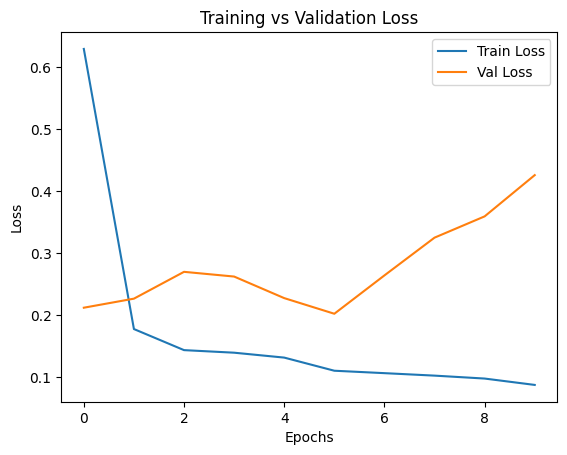

In [ ]:
#training and validation loss to visualize learning progress
plt.plot(train_losses, label="Train Loss")
plt.plot(val_losses, label="Val Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.title("Training vs Validation Loss")
plt.show()

In [ ]:
model.eval() # test accuracy for model evaluation
correct, total = 0, 0
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)
        outputs = model(images)
        _, preds = torch.max(outputs, 1)
        correct += (preds == labels).sum().item()
        total += labels.size(0)

print(f"Test Accuracy: {100 * correct / total:.2f}%")

Test Accuracy: 89.87%


In [11]:
torch.save(model.state_dict(), "../models/baseline_cnn.pt")
print("Baseline model saved")

Baseline model saved
